**Note:** This notebook is written in the Julia language, so the cells
  can't be executed in Google Colab. If you want to verify that the
  notebook works, I recommend [JuliaBox](https://juliabox.com/) (which
  is free and requires no installation) or testing locally. The syntax
  is very similar to Python and MATLAB. Note in particular the dot
  syntax used to perform elementwise operations ( `f.(x)` applies `f`
  to all elements of `x` ), that indices start at 1 and that the last
  statement of all functions is returned automatically.

**Extra note:** The creators of Julia recently received the Wilkinson
  Prize for Numerical Software, a prize also awarded to the creator of
  the Triangle mesh generator. Here is a
  [talk](https://www.youtube.com/watch?v=OfMP5PTFQk0&feature=youtu.be)
  from the event.

# **Lab 7: Optimization and learning**
**Anders Ågren Thuné**

# **Abstract**

# **About the code**

In [1]:
"""
DD2363 Methods in Scientific Computing,
KTH Royal Institute of Technology, Stockholm, Sweden.
"""

# Copyright (C) 2019
# Anders Ågren Thuné (athune@kth.se)
# Johan Hoffman (jhoffman@kth.se)

# Code written by Anders Ågren Thuné based on the template by Johan Hoffman.

# This file is part of the course DD2363 Methods in Scientific Computing
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

"DD2363 Methods in Scientific Computing,\nKTH Royal Institute of Technology, Stockholm, Sweden.\n"

# **Set up environment**

In [2]:
using LinearAlgebra
using Plots

# **Introduction**

Optimization is the study of finding the optimal value of some domain,
typically the maximum or minimum of some function. This is a field
with a broad range of applications, not least in the rapidly growing
field of machine learning.

In order to find the critical points of a function, the derivative
or multivariate versions thereof are typically powerful tools, as they
indicate the direction to move in the input space to achieve the largest
change in the output, the 'steepest slope' in a sense.

Two methods making use of this fact to perform unconstrained
optimization in $\mathbb{R}^n$ are the gradient descent method and the
Newton method. The gradient descent method is typically used when
training artificial neural networks, as it is a relatively cheap way
to find minima of a cost function, especially when a stochastic
version is used.

[Hoffman 2019, Chapter 19]

This report presents how the gradient descent and Newton methods were
implemented in the Julia language. In addition, a simple feedforward
neural network was implemented and trained using the backpropagation
algorithm.

# **Methods**

### **Gradient descent and Newton's method**

Gradient descent and Newton's method are similar in that they utilize
the fact that the gradient indicates the direction of steepest ascent
to step through the input space to search for an optimum. However,
while gradient descent uses a step size $\alpha^{k}$ determined
somewhat heuristically, Newton's method uses the Hessian to determine
the update, resulting in a somewhat more expensive method, but with a
higher order of convergence. Also, as multiplying with the Hessian
might result in either a negative or positive update depending on the
function, Newton's method will find a _stationary point_, as opposed
to a minimum specifically.

Gradient descent: $$x^{(k+1)} = x^{(k)} - \alpha^{(k)}\nabla
f(x^{(k)}),$$ $$\text{for $\alpha^{(k)}$ so that}\ f(x^{(k+1)}) \leq
\beta f(x^{(k)}), \quad \text{where}\ \beta < 1\ \text{is a fixed
parameter}$$

Newton's method: $$x^{(k+1)} = x^{(k)} - (Hf(x^{(k)}))^{-1}\nabla
f(x^{(k)}) $$

In [3]:
"""
Calculate J(f)(p), modifying `jac` in place. Reused from lab 5.
"""
function filljacobian!(jac, f, p, h = 1e-5)
    p1 = p
    p2 = copy(p1)
    for i in 1:length(p)
        p1[i] += h
        p2[i] -= h

        jac[:,i] .= (f(p1) - f(p2)) / 2h

        p1[i] -= h
        p2[i] += h
    end
end

"""
Calculate ∇(f)(x), modifying `v` in place.
"""
fillgradient!(v, f, p, h = 1e-5) = filljacobian!(v', f, p, h)

"""
Use gradient descent to find x* such that ||∇(f)(x*)|| < TOL
Use α = `α` initially, refining it if f(x^(k+1)) > βf(x^(k))
"""
function gradient_descent(f, β, x⁽⁰⁾, α = 0.1, TOL = 1e-6; maxiter::Int = 2000)
    x = copy(x⁽⁰⁾)
    ∇f = Inf*ones(length(x))
    temp_∇f = zeros(length(x))
    prev_f = f(x)
    i = 1
    while norm(∇f) >= TOL && i < maxiter
        fillgradient!(∇f, f, x)
        x .-= α .* ∇f
        while (new_f = f(x)) > β*prev_f # refine alpha and adjust x if we over/undershoot
            fillgradient!(temp_∇f, f, x)
            if (dot(∇f, temp_∇f) > 0)
               α *= 1.2
               x .-= 0.2α .* ∇f
            else 
               α *= 0.8
               x .+= 0.2α .* ∇f
            end
        end
        prev_f = new_f
        i += 1
    end
    x
end

"""
Use Newton's method to find x* such that ||∇(f)(x*)|| < TOL
"""
function newton_optimization(f, H, x⁽⁰⁾, TOL = 1e-6; maxiter::Int = 2000)
    x = copy(x⁽⁰⁾)
    ∇f = Inf*ones(length(x⁽⁰⁾))
    i = 1
    while norm(∇f) >= TOL && i < maxiter
        fillgradient!(∇f, f, x)
        x .-= H(x) \ ∇f
    end
    x
end

newton_optimization

# **Results**

This section presents verification and visualization of the implemented methods.

In [71]:
parabolic(x) = x[1]^2 + x[2]^2
parabolicHessian(x) = [2. 0; 0 2]

sinusoidal(x) = sin(x[1])+cos(x[2])
sinusoidalHessian(x) = [-sin(x[1]) 0; 0 -cos(x[2])]

xgrid = range(-3.5,stop=3.5,length=100)

-3.5:0.0707070707070707:3.5

In [72]:
x⁽⁰⁾ = [-0.5, -0.5]
xs_gradient_descent = [x⁽⁰⁾]
x = gradient_descent(parabolic, 0.999, xs_gradient_descent[end], maxiter = 5)
while x != xs_gradient_descent[end]
    push!(xs_gradient_descent, x)
    x = gradient_descent(parabolic, 0.999, x, maxiter = 5)
end
xs_newton = [x⁽⁰⁾]
x = newton_optimization(parabolic, parabolicHessian, xs_newton[end], maxiter = 5)
while x != xs_newton[end]
    push!(xs_newton, x)
    x = newton_optimization(parabolic, parabolicHessian, x, maxiter = 15)
end

xs_gradient_descent = hcat(xs_gradient_descent...)'
xs_newton = hcat(xs_newton...)'

3×2 Adjoint{Float64,Array{Float64,2}}:
 -0.5         -0.5        
 -1.9294e-22   1.30178e-22
  0.0          0.0        

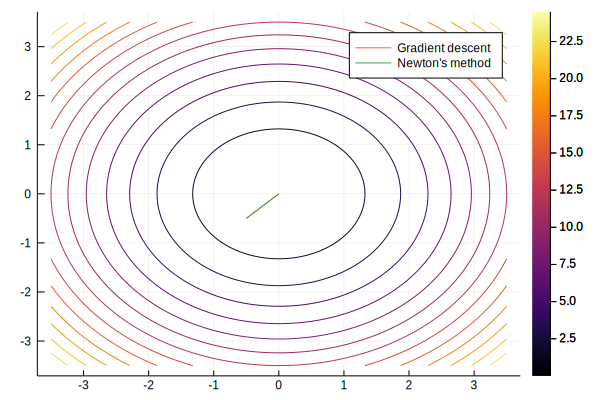

In [73]:
contour(xgrid, xgrid, (x,y) -> parabolic([x,y]))
plot!(xs_gradient_descent[:,1], xs_gradient_descent[:,2], label = "Gradient descent")
plot!(xs_newton[:,1], xs_newton[:,2], label = "Newton's method")

In [74]:
x⁽⁰⁾ = [-0.5, -0.5]
xs_gradient_descent = [x⁽⁰⁾]
x = gradient_descent(sinusoidal, 0.8, xs_gradient_descent[end], 0.01, maxiter = 5)
while x != xs_gradient_descent[end]
    push!(xs_gradient_descent, x)
    x = gradient_descent(sinusoidal, 0.8, x, maxiter = 5)
end
xs_newton = [x⁽⁰⁾]
x = newton_optimization(sinusoidal, sinusoidalHessian, xs_newton[end], maxiter = 5)
while x != xs_newton[end]
    push!(xs_newton, x)
    x = newton_optimization(sinusoidal, sinusoidalHessian, x, maxiter = 15)
end

xs_gradient_descent = hcat(xs_gradient_descent...)'
xs_newton = hcat(xs_newton...)'

2×2 Adjoint{Float64,Array{Float64,2}}:
 -0.5     -0.5        
 -1.5708   1.38915e-12

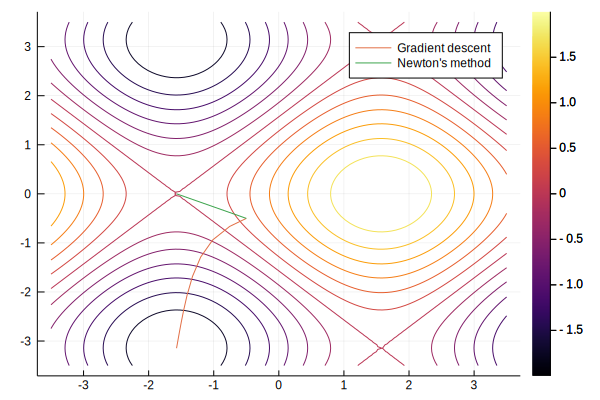

In [75]:
contour(xgrid, xgrid, (x,y) -> sinusoidal([x,y]))
plot!(xs_gradient_descent[:,1], xs_gradient_descent[:,2], label = "Gradient descent")
plot!(xs_newton[:,1], xs_newton[:,2], label = "Newton's method")

We see that Newton's method finds a saddle point, whereas gradient descent searches
out a minimum.

In [76]:
println("Steps required for gradient descent: $(size(xs_gradient_descent, 1))")
println("Steps required for newton: $(size(xs_newton, 1))")

Steps required for gradient descent: 142
Steps required for newton: 2


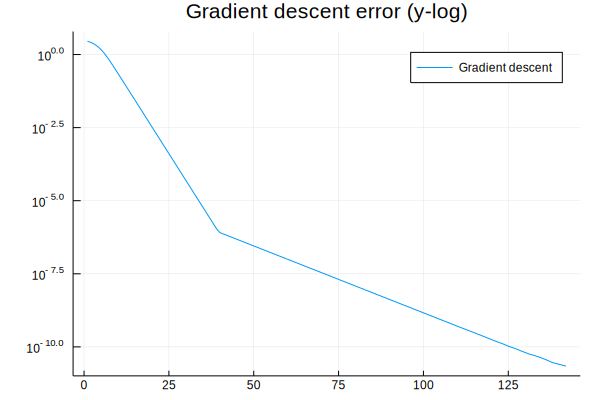

In [77]:
plot([norm(xs_gradient_descent[i,:].-[-π/2, -π])
for i in 1:size(xs_gradient_descent, 1)],
yscale = :log10, label = "Gradient descent", title = "Gradient descent error (y-log)")

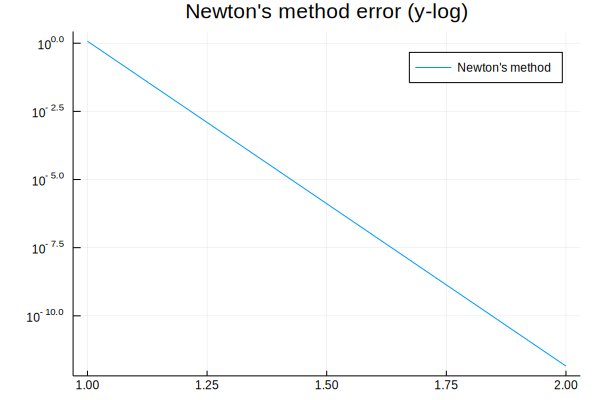

In [78]:
plot(1:size(xs_newton, 1), [norm(xs_newton[i,:].-[-π/2, 0]) for i in 1:size(xs_newton, 1)], yscale = :log10,
label = "Newton's method", title = "Newton's method error (y-log)")

# **Discussion**

# **References**

- Hoffman, J. 2019. *Introduction to Scientific Computing*